In [1]:

# Imports et paramètres
import os, sys, numpy as np, pandas as pd, tensorflow as tf, keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path: sys.path.append(root)

from data.DataManager  import DataManager
from dl_models.CNNs    import create_cnn_model_test      

SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED)

train_assets = ["TRXUSDT", "MATICUSDT", "ADAUSDT", "DOTUSDT"]
test_assets  = ["SOLUSDT", "XRPUSDT"]

train_periods = [(2023, 7), (2023, 8), (2023, 9)]     
test_year , test_month = 2023, 10                     

minutes_per_day = 1_440
daily           = False                              


In [2]:

def reduce_labels_per_day_asset(y_full: np.ndarray, meta: pd.DataFrame)->np.ndarray:
    df = pd.DataFrame({
        "y":      y_full,
        "symbol": meta["symbol"].values,
        "day":    meta["day"].values
    })
    return (df.groupby(["symbol", "day"], sort=False)["y"]
              .mean()
              .values.astype(np.float32))


In [3]:

# Collecte & normalisation TRAIN sur les actifs
X_tr_all, y_tr_all = [], []

for sym in train_assets:
    for (yy, mm) in train_periods:
        dm = DataManager([sym], yy, mm, light=True)
        dm.download_and_prepare_data()
        dm.build_features(daily=daily, serial_dependency=False)
        dm.build_labels()

        X_m, y_m_full = dm.build_training_data(daily=daily, serial_dependency=False)
        y_m           = reduce_labels_per_day_asset(y_m_full, dm.meta)

        X_tr_all.append(X_m)
        y_tr_all.append(y_m)

X_tr_raw = np.concatenate(X_tr_all, axis=0)          # (n_minutes, 11)
y_tr_raw = np.concatenate(y_tr_all, axis=0)          # (n_days,)

# scalers appris sur tout le train 
scaler_X = StandardScaler().fit(X_tr_raw)
scaler_y = StandardScaler().fit(y_tr_raw.reshape(-1,1))

X_tr_s = scaler_X.transform(X_tr_raw)
y_tr_s = scaler_y.transform(y_tr_raw.reshape(-1,1)).flatten()

#  reshape en séquences (1440,11) 
dm_dummy = DataManager([train_assets[0]], train_periods[0][0], train_periods[0][1], light=True)
X_tr_cnn, y_tr_cnn = dm_dummy.format_data(
    X_tr_s, y_tr_s,
    model_type='cnn',
    daily=daily,
    nb_assets=1,
    minutes_per_day=minutes_per_day
)
print("TRAIN CNN :", X_tr_cnn.shape, y_tr_cnn.shape)  


⚠️ Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\TRXUSDT-1m-2023-07.parquet
⚠️ BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\TRXUSDT-bookTicker-2023-07.parquet
✅ Fichier déjà existant, ignoré : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\minute features data\TRXUSDT-1m-2023-07_features_1min_klines.parquet
✅ Fichier déjà existant, ignoré : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\labels data\TRXUSDT-bookTicker-2023-07_labels.parquet
✅ Données prêtes : X.shape = (44640, 11), y.shape = (44640,)
⚠️ Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\TRXUSDT-1m-2023-08.parquet
⚠️ BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\TRXUSDT-bookT

In [4]:

# Création et entraînement du CNN
input_shape = X_tr_cnn.shape[1:]     # (1440, 11)
cnn = create_cnn_model_test(input_shape=input_shape, model_type="simple")
cnn.compile(optimizer='adam', loss='mse')

history = cnn.fit(
    X_tr_cnn, y_tr_cnn,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=5,
                                             restore_best_weights=True)]
)


Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.9483 - val_loss: 2.9615
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5506 - val_loss: 2.9615
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5506 - val_loss: 2.9615
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5506 - val_loss: 2.9615
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5506 - val_loss: 2.9615
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5506 - val_loss: 2.9615


In [5]:

# Préparation TEST sur actifs 

X_te_all, y_te_all, asset_id = [], [], []

for sym in test_assets:
    dm = DataManager([sym], test_year, test_month, light=True)
    dm.download_and_prepare_data()
    dm.build_features(daily=daily, serial_dependency=False)
    dm.build_labels()

    X_m, y_m_full = dm.build_training_data(daily=daily, serial_dependency=False)
    y_m           = reduce_labels_per_day_asset(y_m_full, dm.meta)        # (31,)

    # même scalers que le train
    X_s = scaler_X.transform(X_m)
    y_s = scaler_y.transform(y_m.reshape(-1,1)).flatten()

    X_cnn, y_cnn = dm.format_data(
        X_s, y_s,
        model_type='cnn',
        daily=daily,
        nb_assets=1,
        minutes_per_day=minutes_per_day
    )

    X_te_all.append(X_cnn)
    y_te_all.append(y_cnn)
    asset_id.extend([sym]*len(y_cnn))

X_te_cnn = np.concatenate(X_te_all, axis=0)    # (62, 1440, 11)  si 31 j × 2 actifs
y_te_cnn = np.concatenate(y_te_all, axis=0)
print("TEST CNN :", X_te_cnn.shape, y_te_cnn.shape)


⚠️ Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\SOLUSDT-1m-2023-10.parquet
⚠️ BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\SOLUSDT-bookTicker-2023-10.parquet
✅ Fichier déjà existant, ignoré : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\minute features data\SOLUSDT-1m-2023-10_features_1min_klines.parquet
✅ Fichier déjà existant, ignoré : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\labels data\SOLUSDT-bookTicker-2023-10_labels.parquet
✅ Données prêtes : X.shape = (44640, 11), y.shape = (44640,)
⚠️ Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\XRPUSDT-1m-2023-10.parquet
⚠️ BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\XRPUSDT-bookT

In [ ]:

# Prédiction et inverse-scaling

y_pred_s = cnn.predict(X_te_cnn, verbose=0).flatten()
y_pred   = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
y_true   = scaler_y.inverse_transform(y_te_cnn.reshape(-1,1)).flatten()

mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"\GLOBAL METRICS")
print(f"MSE  : {mse: .6e}")
print(f"RMSE : {rmse: .6f}")
print(f"MAE  : {mae: .6f}")
print(f"R²   : {r2: .4f}")



══════════  GLOBAL METRICS  ══════════
MSE  :  5.221815e-07
RMSE :  0.000723
MAE  :  0.000586
R²   : -0.3848


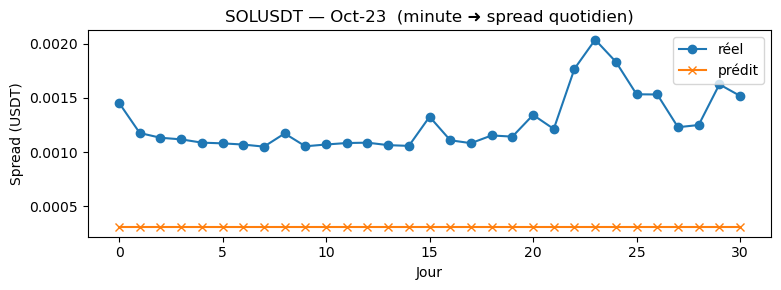

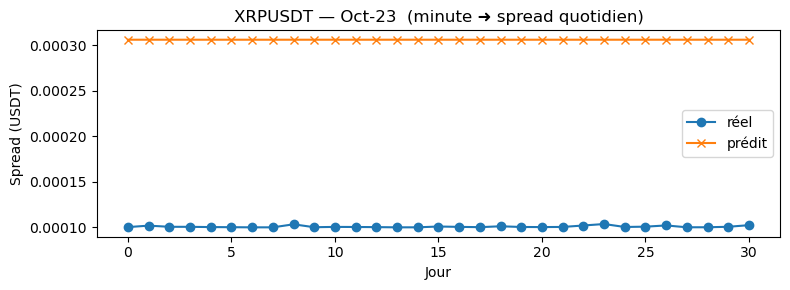

In [7]:

# Visualisation par actif

df_vis = pd.DataFrame({
    "asset": asset_id,
    "true":  y_true,
    "pred":  y_pred
})
for sym in test_assets:
    sub = df_vis[df_vis["asset"]==sym].reset_index(drop=True)
    plt.figure(figsize=(8,3))
    plt.plot(sub["true"], label="réel", marker='o')
    plt.plot(sub["pred"], label="prédit", marker='x')
    plt.title(f"{sym} — Oct-23  (minute ➜ spread quotidien)")
    plt.xlabel("Jour"); plt.ylabel("Spread (USDT)")
    plt.legend(); plt.tight_layout(); plt.show()
